In [1]:
import os
import pickle
import pprint
from pathlib import Path
from collections import OrderedDict, defaultdict
from easydict import EasyDict

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from tqdm import tqdm

from batch_engine import valid_trainer, batch_trainer
from config import argument_parser
from dataset.AttrDataset import AttrDataset, get_transform
from loss.CE_loss import CEL_Sigmoid
from models.base_block import FeatClassifier, BaseClassifier
from models.resnet import resnet50, resnet101

from tools.function import get_model_log_path, get_pedestrian_metrics
from tools.utils import time_str, save_ckpt, ReDirectSTD, set_seed, AverageMeter
from tools.attributes_dict import attr_list
import pdb

In [2]:
args = EasyDict()
args.dataset = "test"
args.redirector = True
# args.device
args.valid_split = "test"
args.test_batchsize = 1
args.attr_num = 48
args.height = 256
args.width = 192
args.threshold = 0.5
args.print = True
# args.pretrained_model = '/home/pantengteng/Programs/Strong_Baseline_of_Pedestrian_Attribute_Recognition/exp_result/PETA/2020-12-10_16:17:39_ep_30_bs_64/img_model/ckpt_max.pth' 
# args.pretrained_model = '/home/pantengteng/Programs/Strong_Baseline_of_Pedestrian_Attribute_Recognition/exp_result/PA100k/2020-12-10_20:28:54_ep_30_bs_64/img_model/ckpt_max.pth' 

In [3]:
def get_reload_weight(model_path, model):
    # 加载到cpu
    model_dict = torch.load(model_path, map_location=lambda storage, loc: storage)
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in model_dict["state_dicts"].items():
        name = k[7:]  # 去掉 `module.`
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)
    return model
def run_model(args):
    visenv_name = args.dataset
    exp_dir = os.path.join('exp_result', args.dataset)
    model_dir, log_dir = get_model_log_path(exp_dir, visenv_name)
    stdout_file = os.path.join(log_dir, f'stdout_{time_str()}.txt')

    if args.redirector:
        print('redirector stdout')
        ReDirectSTD(stdout_file, 'stdout', False)

    pprint.pprint(OrderedDict(args.__dict__))

    print('-' * 60)


    train_tsfm, valid_tsfm = get_transform(args)

    valid_set = AttrDataset(args=args, split=args.valid_split, transform=valid_tsfm)

    valid_loader = DataLoader(
        dataset=valid_set,
        batch_size=args.test_batchsize,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )

    print(f'{args.valid_split} set: {len(valid_loader.dataset)}, '
          f'attr_num : {args.attr_num}')

    backbone = resnet50()
    classifier = BaseClassifier(nattr=args.attr_num)
    model = FeatClassifier(backbone, classifier)
    pdb.set_trace()
    # if torch.cuda.is_available():
    #     model = torch.nn.DataParallel(model).cuda()

    print("reloading pretrained models")

    model_path = args.pretrained_model
    model = get_reload_weight(model_path, model)

    model.eval()
    preds_probs = []
    gt_list = []
    with torch.no_grad():
        for step, (imgs, gt_label, imgname) in enumerate(tqdm(valid_loader)):
            # imgs = imgs.cuda()
            # gt_label = gt_label.cuda()
            gt_list.append(gt_label.cpu().numpy())
            # gt_label[gt_label == -1] = 0
            valid_logits = model(imgs)
            valid_probs = torch.sigmoid(valid_logits)
            preds_probs.append(valid_probs.cpu().numpy())
    gt_label = np.concatenate(gt_list, axis=0)  # [0:8] + gt_list[22:33]
    preds_probs = np.concatenate(preds_probs, axis=0) # [0:8] + preds_probs[22:33]
    # preds_probs = np.concatenate(preds_probs, axis=0)
    gt_label = np.concatenate((gt_label[:,0:8], gt_label[:,22:33]),1)
    preds_probs = np.concatenate((preds_probs[:,0:8], preds_probs[:,22:33]),1)
    valid_result = get_pedestrian_metrics(gt_label, preds_probs, threshold=args.threshold)
    if args.print:
        print(f'Evaluation on test set, \n',
          'ma: {:.4f},  pos_recall: {:.4f} , neg_recall: {:.4f} \n'.format(
              valid_result.ma, np.mean(valid_result.label_pos_recall), np.mean(valid_result.label_neg_recall)),
          'Acc: {:.4f}, Prec: {:.4f}, Rec: {:.4f}, F1: {:.4f}'.format(
              valid_result.instance_acc, valid_result.instance_prec, valid_result.instance_recall,
              valid_result.instance_f1))
    return valid_result #gt_label, pred_probs

In [4]:
# peta
args.pretrained_model = '/home/pantengteng/Programs/Strong_Baseline_of_Pedestrian_Attribute_Recognition/exp_result/PETA/2020-12-10_16:17:39_ep_30_bs_64/img_model/ckpt_max.pth' 
#args.pretrained_model = '/home/pantengteng/Programs/Strong_Baseline_of_Pedestrian_Attribute_Recognition/exp_result/PA100k/2020-12-10_20:28:54_ep_30_bs_64/img_model/ckpt_max.pth' 
# gt_label0, preds_probs0 = run_model(args)
# peta_valid_result = get_pedestrian_metrics(gt_label0, preds_probs0, threshold=args.threshold)
peta_valid_result = run_model(args)
# pa100k
args.pretrained_model = '/home/pantengteng/Programs/Strong_Baseline_of_Pedestrian_Attribute_Recognition/exp_result/PA100k/2020-12-10_20:28:54_ep_30_bs_64/img_model/ckpt_max.pth' 
# gt_label1, preds_probs1 = run_model(args)
# pa100k_valid_result = get_pedestrian_metrics(gt_label1, preds_probs1, threshold=args.threshold)
pa100k_valid_result = run_model(args)
# combined
args.pretrained_model = '/home/pantengteng/Programs/Strong_Baseline_of_Pedestrian_Attribute_Recognition/exp_result/combined/2020-12-12_11:42:11_ep_30_bs_64/img_model/ckpt_max.pth'
# gt_label2, preds_probs2 = run_model(args)
# combined_valid_result = get_pedestrian_metrics(gt_label2, preds_probs2, threshold=args.threshold)
combined_valid_result = run_model(args)

redirector stdout
OrderedDict([('dataset', 'test'),
             ('redirector', True),
             ('valid_split', 'test'),
             ('test_batchsize', 1),
             ('attr_num', 48),
             ('height', 256),
             ('width', 192),
             ('threshold', 0.5),
             ('print', True),
             ('pretrained_model',
              '/home/pantengteng/Programs/Strong_Baseline_of_Pedestrian_Attribute_Recognition/exp_result/PETA/2020-12-10_16:17:39_ep_30_bs_64/img_model/ckpt_max.pth')])
------------------------------------------------------------
test set: 140, attr_num : 48
> <ipython-input-3-c1831340b30c>(48)run_model()
     46     #     model = torch.nn.DataParallel(model).cuda()
     47 
---> 48     print("reloading pretrained models")
     49 
     50     model_path = args.pretrained_model

ipdb> n
reloading pretrained models
> <ipython-input-3-c1831340b30c>(50)run_model()
     48     print("reloading pretrained models")
     49 
---> 50     model_path = a

  0%|          | 0/140 [00:00<?, ?it/s]

> <ipython-input-3-c1831340b30c>(60)run_model()
     58         # imgs = imgs.cuda()
     59         # gt_label = gt_label.cuda()
---> 60         gt_list.append(gt_label.cpu().numpy())
     61         # gt_label[gt_label == -1] = 0
     62         valid_logits = model(imgs)

ipdb> 
> <ipython-input-3-c1831340b30c>(62)run_model()
     60         gt_list.append(gt_label.cpu().numpy())
     61         # gt_label[gt_label == -1] = 0
---> 62         valid_logits = model(imgs)
     63         valid_probs = torch.sigmoid(valid_logits)
     64         preds_probs.append(valid_probs.cpu().numpy())

ipdb> q


  0%|          | 0/140 [01:21<?, ?it/s]


BdbQuit: 

In [5]:
POSITIVE = 1
NEGATIVE = 0
baidu_dict = {
    'Female': {'gender': '女性'},
    # 'Male': {'gender':'男性'},
    'AgeLess16': {'age': ['幼儿', '青少年']},
    'Age17-45': {'age': '青年'},
    'Age46-60': {'age': '中年'},
    'Ageover60': {'age': '老年'},
    'Front': {'orientation': '正面'},
    'Side': {'orientation': ['左侧面', '右侧面']},
    'Back': {'orientation': '背面'},
    'a-Backpack': {'bag': '双肩包'},
    'a-ShoulderBag': {'bag': '单肩包'},
    'hs-Hat': {'headwear': '普通帽'},
    'hs-Glasses': {'glasses': '戴眼镜'},
    'ub-ShortSleeve': {'upper_wear': '短袖'},
    'ub-LongSleeve': {'upper_wear': '长袖'},
    'ub-Shirt': {'upper_wear_fg': '衬衫'},
    'ub-Sweater': {'upper_wear_fg': '毛衣'},
    'ub-Vest': {'upper_wear_fg': '无袖'},
    'ub-TShirt': {'upper_wear_fg': 'T恤'},
    'ub-Cotton': {'upper_wear_fg': '羽绒服'},
    'ub-Jacket': {'upper_wear_fg': ['外套', '夹克']},
    'ub-SuitUp': {'upper_wear_fg': '西装'},
    'ub-Coat': {'upper_wear_fg': '风衣'},  # coat这里仅指风衣
    'ub-Black': {'upper_color': '黑'},
    'ub-Blue': {'upper_color': '蓝'},
    'ub-Brown': {'upper_color': '棕'},
    'ub-Green': {'upper_color': '绿'},
    'ub-Grey': {'upper_color': '灰'},
    'ub-Orange': {'upper_color': '橙'},
    'ub-Pink': {'upper_color': '粉'},
    'ub-Purple': {'upper_color': '紫'},
    'ub-Red': {'upper_color': '红'},
    'ub-White': {'upper_color': '白'},
    'ub-Yellow': {'upper_color': '黄'},
    'lb-LongTrousers': {'lower_wear': '长裤'},
    'lb-Shorts': {'lower_wear': '短裤'},
    'lb-ShortSkirt': {'lower_wear': '短裙'},
    'lb-Dress': {'lower_wear': '长裙'},
    'lb-Black': {'lower_color': '黑'},
    'lb-Blue': {'lower_color': '蓝'},
    'lb-Brown': {'lower_color': '棕'},
    'lb-Green': {'lower_color': '绿'},
    'lb-Grey': {'lower_color': '灰'},
    'lb-Orange': {'lower_color': '橙'},
    'lb-Pink': {'lower_color': '粉'},
    'lb-Purple': {'lower_color': '紫'},
    'lb-Red': {'lower_color': '红'},
    'lb-White': {'lower_color': '白'},
    'lb-Yellow': {'lower_color': '黄'}
}
# 生成baidu的np.array
save_dir = '/home/pantengteng/Programs/Strong_Baseline_of_Pedestrian_Attribute_Recognition/data/test'

baidu_json = "/home/pantengteng/Programs/Strong_Baseline_of_Pedestrian_Attribute_Recognition/baidu.json"

with open(baidu_json, "r") as f:
    db_label_list = json.load(f)

# 将名字放入index_list中
index_list = [data["img_name"] for data in db_label_list]

img_list = (Path(save_dir) / "images").glob("*")
label_list = []
dataset = EasyDict()
dataset.image_name = []

dataset1 = EasyDict()
dataset1.image_name = []

# 将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标
for id, img in enumerate(img_list):
    dataset.image_name.append(str(img))
    bd_label = db_label_list[index_list.index(img.name)]
    label = []
    for index, att in enumerate(attr_list):
        # 字典需要获取key
        sub_key = list(baidu_dict[att].keys())[0]
        da_att = bd_label["person_info"][0]["attributes"][sub_key]["name"]
        if isinstance(baidu_dict[att][sub_key], list):
            if da_att in baidu_dict[att][sub_key]:
                label.append(POSITIVE)
            else:
                label.append(NEGATIVE)
        else:
            if da_att == baidu_dict[att][sub_key]:
                label.append(POSITIVE)
            else:
                label.append(NEGATIVE)
    label_list.append(label)
preds_probs4 = np.array(label_list)
print('aaa')

# 生成真实标签的np.array
org_json = "/home/pantengteng/Programs/Strong_Baseline_of_Pedestrian_Attribute_Recognition/new_data_copy.json"
with open(org_json, "r") as f:
    org_label_list = json.load(f)
index_list = [data["img_name"] for data in org_label_list]
img_list = (Path(save_dir) / "images").glob("*")
label_list = []
for id, img in enumerate(img_list):
    dataset1.image_name.append(str(img))
    org_label = org_label_list[index_list.index(img.name)]
    label = []
    for index, att in enumerate(attr_list):
        # test有对应标签
        if att in org_label["attribute"]:
            label.append(POSITIVE)
        else:
            label.append(NEGATIVE)
    label_list.append(label)

gt_label4 = np.array(label_list)
gt_label4 = np.concatenate((gt_label4[:,0:8], gt_label4[:,22:33]),1)
preds_probs4 = np.concatenate((preds_probs4[:,0:8], preds_probs4[:,22:33]),1)
baidu_valid_result = get_pedestrian_metrics(gt_label4, preds_probs4, threshold=0.4)

In [6]:
print('Evaluation on test set, \n',
  'ma: {:.4f},  pos_recall: {:.4f} , neg_recall: {:.4f} \n'.format(
      baidu_valid_result.ma, np.mean(baidu_valid_result.label_pos_recall), np.mean(baidu_valid_result.label_neg_recall)),
  'Acc: {:.4f}, Prec: {:.4f}, Rec: {:.4f}, F1: {:.4f}'.format(
      baidu_valid_result.instance_acc, baidu_valid_result.instance_prec, baidu_valid_result.instance_recall,
      baidu_valid_result.instance_f1))

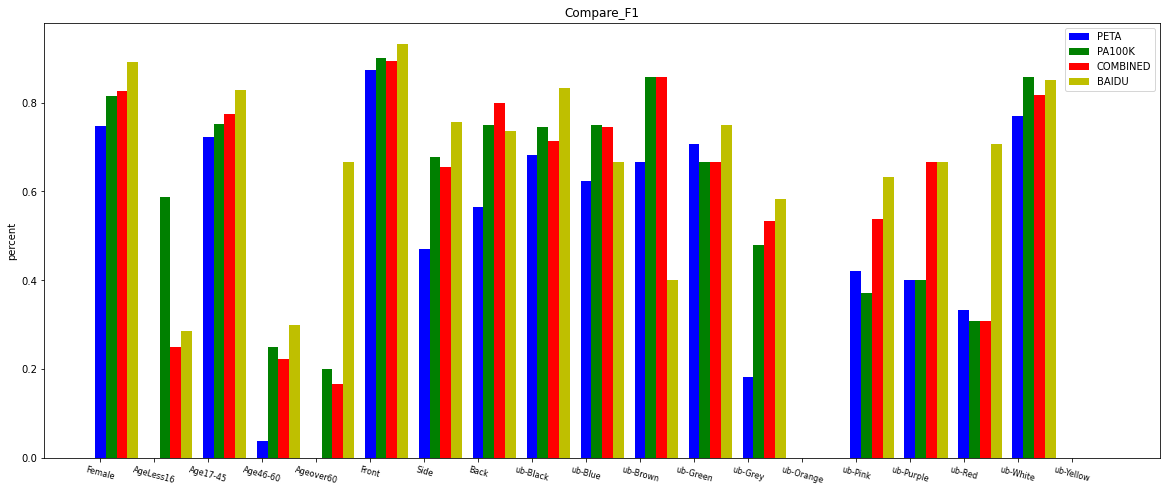

In [17]:
# 输入统计数据
atts = attr_list[0:8] + attr_list[22:33]
# atts = attr_list[8:22] + attr_list[33:]

bar_width = 0.2 # 0.3  # 条形宽度
index_PETA = np.arange(len(atts))  # PETA的横坐标
index_PA100K = index_PETA + bar_width  # pa100k的横坐标
index_COMBINED = index_PA100K + bar_width
index_BAIDU = index_COMBINED + bar_width  #BAIDU的横坐标

plt.figure(figsize=(20,8)) 
# 使用两次 bar 函数画出两组条形图
# label_prec, 
plt.bar(index_PETA, height=np.concatenate((peta_valid_result.label_f1[0:8],peta_valid_result.label_f1[22:33]), 0), width=bar_width, color='b', label='PETA')
plt.bar(index_PA100K, height=np.concatenate((pa100k_valid_result.label_f1[0:8],pa100k_valid_result.label_f1[22:33]), 0), width=bar_width, color='g', label='PA100K')
plt.bar(index_COMBINED, height=np.concatenate((combined_valid_result.label_f1[0:8],combined_valid_result.label_f1[22:33]), 0), width=bar_width, color='r', label='COMBINED')
plt.bar(index_BAIDU, height=np.concatenate((baidu_valid_result.label_f1[0:8],baidu_valid_result.label_f1[22:33]), 0), width=bar_width, color='y', label='BAIDU')
# plt.bar(index_R, height=valid_result.label_neg_recall, width=bar_width, color='r', label='neg_recall')
#plt.bar(index_PETA, height=np.concatenate((peta_valid_result.label_neg_recall[8:22],peta_valid_result.label_neg_recall[33:]), 0), width=bar_width, color='b', label='PETA')
#plt.bar(index_PA100K, height=np.concatenate((pa100k_valid_result.label_neg_recall[8:22],pa100k_valid_result.label_neg_recall[33:]), 0), width=bar_width, color='g', label='PA100K')
#plt.bar(index_COMBINED, height=np.concatenate((combined_valid_result.label_neg_recall[8:22],combined_valid_result.label_neg_recall[33:]), 0), width=bar_width, color='r', label='COMBINED')
#plt.bar(index_BAIDU, height=np.concatenate((baidu_valid_result.label_neg_recall[8:22],baidu_valid_result.label_neg_recall[33:]), 0), width=bar_width, color='y', label='BAIDU')


plt.legend()  # 显示图例
plt.xticks(index_PETA, atts) #+ bar_width/2
plt.tick_params(axis='x', labelsize=8)
plt.xticks(rotation=-15) 
plt.ylabel('percent')  # 纵坐标轴标题
plt.title('Compare_F1')  # 图形标题
plt.savefig('./test_comareAll_f1.jpg')

plt.show()